In [1]:
# imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.metrics import topk_acc, real_acc, AverageMeter
from utils.parsers import get_training_parser
from utils.optimizer import get_optimizer, get_scheduler, OPTIMIZERS_DICT, SCHEDULERS

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt
import argparse
import time


In [2]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
#data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [8]:
# TODO: Do not forget to choose GPU as runtime
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# TODO: Create a folder called 'checkpoints'. It is already included in the .gitignore file
# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)




Weights already downloaded
Load_state output <All keys matched successfully>


In [9]:
import argparse

In [10]:
argparse.BooleanOptionalAction

argparse.BooleanOptionalAction

In [11]:
# model.cuda()

In [12]:
x = torch.randn(1, 3, 64, 64)
x = x.flatten()
x.shape

torch.Size([12288])

### Import dataset and initialize the DataLoader

In [13]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10_dataset, batch_size=1000, shuffle=True)


cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified


### For each class, calculate the mean image

In [89]:
num_class = 10
cmeans = [[] for i in range(num_class)]
r = 0
for x,y in loader:
    r+=1
    for c in range(num_class):
        cmeans[c].append(x[y==c])


In [90]:
clist = [torch.cat(cmeans[i]).mean(dim=0) for i in range(num_class)]

In [ ]:
cclist = [c.unsqueeze(0) for c in clist]
centers = torch.cat(cclist)
centers.shape

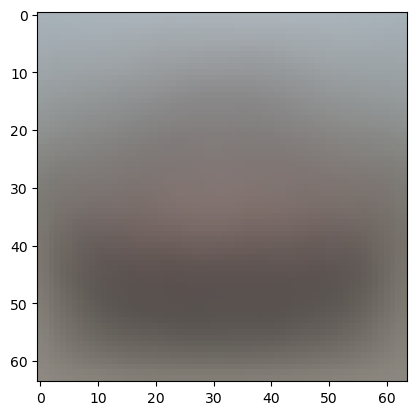

In [91]:
plt.imshow(clist[9].numpy().transpose(1,2,0))

### Define the ClassMaximization class and create an instance of it

In [92]:
x_c = nn.parameter.Parameter(torch.randn(3,64,64))


class ClassMaxim(nn.Module):
    def __init__(self,num_class, centers=None):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(num_class, 3, 64, 64))
        if centers!=None:
            self.x_c = nn.parameter.Parameter(centers.clone())    
        self.clone = self.x_c.clone()

In [94]:
# create the model
clsmax = ClassMaxim(num_class=10, centers=centers)

In [95]:
clsmax.clone==clsmax.x_c

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [100]:
for param in clsmax.parameters():
    print(type(param.data), param.size())

clsmax.x_c[0].shape

<class 'torch.Tensor'> torch.Size([10, 3, 64, 64])


torch.Size([3, 64, 64])

In [110]:
list(clsmax.parameters())

[Parameter containing:
 tensor([[[[0.5686, 0.5681, 0.5661,  ..., 0.5668, 0.5671, 0.5669],
           [0.5690, 0.5684, 0.5664,  ..., 0.5667, 0.5671, 0.5670],
           [0.5688, 0.5682, 0.5661,  ..., 0.5657, 0.5663, 0.5662],
           ...,
           [0.5153, 0.5144, 0.5117,  ..., 0.5086, 0.5098, 0.5100],
           [0.5159, 0.5151, 0.5126,  ..., 0.5089, 0.5097, 0.5098],
           [0.5159, 0.5151, 0.5127,  ..., 0.5086, 0.5093, 0.5092]],
 
          [[0.6323, 0.6318, 0.6297,  ..., 0.6301, 0.6300, 0.6296],
           [0.6327, 0.6321, 0.6301,  ..., 0.6301, 0.6301, 0.6298],
           [0.6327, 0.6320, 0.6297,  ..., 0.6293, 0.6294, 0.6292],
           ...,
           [0.5399, 0.5390, 0.5360,  ..., 0.5337, 0.5348, 0.5349],
           [0.5400, 0.5391, 0.5365,  ..., 0.5333, 0.5341, 0.5341],
           [0.5396, 0.5388, 0.5363,  ..., 0.5326, 0.5333, 0.5333]],
 
          [[0.6989, 0.6984, 0.6963,  ..., 0.6955, 0.6953, 0.6948],
           [0.6992, 0.6986, 0.6965,  ..., 0.6956, 0.6955, 0.6951],
 

In [111]:
parser = get_training_parser()
args = parser.parse_args(args=[])

epoch = 100
num_class=10

loss_fn = CrossEntropyLoss(label_smoothing=args.smooth)
opt = get_optimizer(args.optimizer)(clsmax.parameters(), lr=0.003, weight_decay=args.weight_decay)#args.lr
scheduler = get_scheduler(opt, args.scheduler, **args.__dict__)

In [114]:
start = time.time()
model.eval() # fixed model

# total_acc, total_top5 = AverageMeter(), AverageMeter()
total_loss = AverageMeter()

for step in range(40):
    for c in range(1):
        xx = clsmax.x_c[c].flatten()#.cuda()
        preds = model(xx)
        targs = torch.tensor(c)#.cuda()


        (-preds[c]).backward()
        # loss = loss_fn(preds, targs)
        
        # loss = loss / args.accum_steps
        # loss.backward()

        print(preds[c])
        
        opt.step()
        opt.zero_grad()
    
        #total_loss.update(loss.item() * args.accum_steps, 1)

end = time.time()

scheduler.step()

tensor(1.5574, grad_fn=<SelectBackward0>)
tensor(2.5286, grad_fn=<SelectBackward0>)
tensor(2.7787, grad_fn=<SelectBackward0>)
tensor(3.0540, grad_fn=<SelectBackward0>)
tensor(3.2471, grad_fn=<SelectBackward0>)
tensor(3.3144, grad_fn=<SelectBackward0>)
tensor(3.2991, grad_fn=<SelectBackward0>)
tensor(3.5806, grad_fn=<SelectBackward0>)
tensor(3.7763, grad_fn=<SelectBackward0>)
tensor(3.9521, grad_fn=<SelectBackward0>)
tensor(4.0764, grad_fn=<SelectBackward0>)
tensor(4.1131, grad_fn=<SelectBackward0>)
tensor(4.3527, grad_fn=<SelectBackward0>)
tensor(4.3751, grad_fn=<SelectBackward0>)
tensor(4.6343, grad_fn=<SelectBackward0>)
tensor(4.7068, grad_fn=<SelectBackward0>)
tensor(4.8893, grad_fn=<SelectBackward0>)
tensor(5.0124, grad_fn=<SelectBackward0>)
tensor(5.1493, grad_fn=<SelectBackward0>)
tensor(5.2786, grad_fn=<SelectBackward0>)
tensor(5.3794, grad_fn=<SelectBackward0>)
tensor(5.4742, grad_fn=<SelectBackward0>)
tensor(5.6504, grad_fn=<SelectBackward0>)
tensor(5.6988, grad_fn=<SelectBack

In [116]:
torch.norm(clsmax.x_c[0])

tensor(62.5754, grad_fn=<LinalgVectorNormBackward0>)

In [117]:
torch.norm(centers[0])

tensor(62.3464)

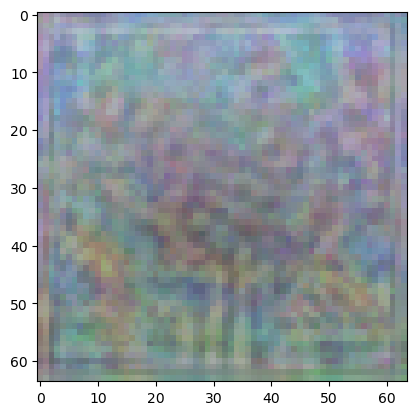

In [118]:
plt.imshow(clsmax.x_c[0].detach().numpy().transpose(1,2,0))

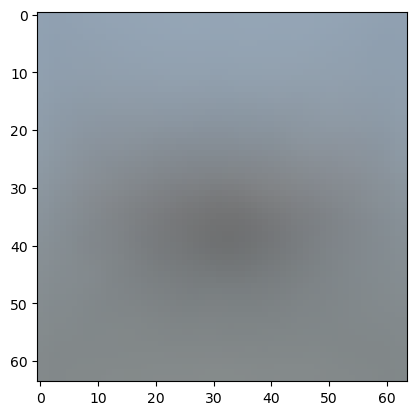

In [119]:
plt.imshow(clsmax.clone[0].detach().numpy().transpose(1,2,0))

In [121]:
clsmax.clone[0]==clsmax.x_c[0]

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False,  True,  True],
         [False, False, False,  ..., False,  True, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False,  True, False,  ..., False, False, False],
         [

# Same thing for CNNs

In [3]:
# USE CNN that is pretrained on cifar10
from cifar10_models.resnet import *
model = resnet18()

In [4]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    # transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

mnist_train_dataset = datasets.MNIST('../mnist_data', 
                                download=True, 
                                train=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(), # first, convert image to PyTorch tensor
                                    transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                ]))# datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train_dataset, batch_size=1000, shuffle=True)



cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

100%|██████████| 9912422/9912422 [00:02<00:00, 4775494.85it/s] 


Extracting ../mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 59467694.56it/s]


Extracting ../mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 14975750.42it/s]


Extracting ../mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4953335.61it/s]

Extracting ../mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw



In [8]:
mnist_test_set = datasets.MNIST('../mnist_data', 
                            download=True, 
                            train=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(), # first, convert image to PyTorch tensor
                                transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                            ]))

mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, 
                                           batch_size=10, 
                                           shuffle=True)

In [47]:
num_class = 10
cmeans = [[] for i in range(num_class)]
r = 0
for x,y in loader:
    r+=1
    for c in range(num_class):
        cmeans[c].append(x[y==c])

In [114]:
len(cmeans[c][3])

95

In [115]:
torch.cat(cmeans[0]).shape

torch.Size([5000, 3, 32, 32])

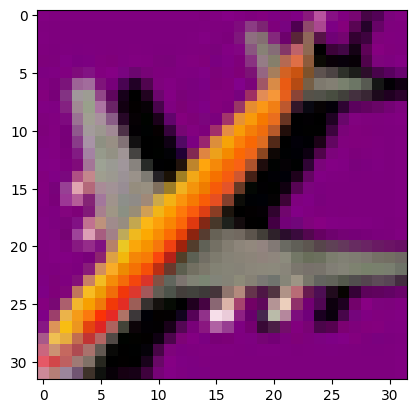

In [122]:
plt.imshow((torch.cat(cmeans[0])[123]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))

In [124]:
torch.cat(cmeans[0]).mean(dim=0).shape

torch.Size([3, 32, 32])

In [48]:
clist = [torch.cat(cmeans[i]).mean(dim=0) for i in range(num_class)]

In [125]:
cclist = [c.unsqueeze(0) for c in clist]
centers = torch.cat(cclist)
centers.shape

torch.Size([10, 3, 32, 32])

In [128]:
centers

tensor([[[[ 3.1257e-01,  2.9659e-01,  3.0632e-01,  ...,  3.1016e-01,
            3.0275e-01,  3.0560e-01],
          [ 3.1089e-01,  2.9386e-01,  3.0242e-01,  ...,  2.9926e-01,
            2.9296e-01,  2.9936e-01],
          [ 3.0559e-01,  2.8566e-01,  2.9294e-01,  ...,  2.8804e-01,
            2.8376e-01,  2.9428e-01],
          ...,
          [ 9.3153e-02,  6.9687e-02,  7.3089e-02,  ...,  5.6257e-02,
            5.7070e-02,  7.1982e-02],
          [ 9.3518e-02,  7.0541e-02,  7.8216e-02,  ...,  6.2682e-02,
            6.2986e-02,  7.3677e-02],
          [ 9.8999e-02,  7.9466e-02,  9.0233e-02,  ...,  7.1360e-02,
            6.6033e-02,  7.2226e-02]],

         [[ 6.1643e-01,  5.9989e-01,  6.0990e-01,  ...,  6.1356e-01,
            6.0559e-01,  6.0542e-01],
          [ 6.1597e-01,  5.9648e-01,  6.0453e-01,  ...,  6.0465e-01,
            5.9807e-01,  6.0048e-01],
          [ 6.0948e-01,  5.8600e-01,  5.9128e-01,  ...,  5.9047e-01,
            5.8621e-01,  5.9379e-01],
          ...,
     

### Define the ClassMaximization class and create an instance of it

In [81]:
x_c = nn.parameter.Parameter(torch.randn(3,64,64))

class ClassMaxim(nn.Module):
    def __init__(self,num_class, centers=None, reso=32):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(num_class, 3, reso, reso))
        if centers!=None:
            self.x_c = nn.parameter.Parameter(centers.clone())    
        self.clone = self.x_c.clone()

In [82]:
centers.shape

torch.Size([10, 3, 32, 32])

In [334]:
# create the model
clsmax = ClassMaxim(num_class=10, centers=centers, reso=32)
# clsmax = ClassMaxim(num_class=10, reso=32)

In [335]:
torch.sum(clsmax.clone!=clsmax.x_c)

tensor(0)

In [336]:
parser = get_training_parser()
args = parser.parse_args(args=[])

epoch = 100
lr = 0.1
num_class=10

loss_fn = CrossEntropyLoss(label_smoothing=args.smooth)
opt = get_optimizer(args.optimizer)(clsmax.parameters(), lr=lr, weight_decay=args.weight_decay)#args.lr
scheduler = get_scheduler(opt, args.scheduler, **args.__dict__)

lamb = 0.1

In [337]:
start = time.time()
model.eval() # fixed model

# total_acc, total_top5 = AverageMeter(), AverageMeter()
total_loss = AverageMeter()

for step in range(1000):
    # for c in range(1):
    c=1
    xx = clsmax.x_c[c]#.flatten()#.cuda()
    #print(xx.size())
    preds = model(xx.unsqueeze(0)) # cnn 1 x 3 x 32 x 32, expected dim
    preds = preds.squeeze(0)

    print(preds.size())
    targs = torch.tensor(c)#.cuda()

    loss = (preds[c] - lamb*(torch.norm(clsmax.x_c[c])))
    (loss).backward()
    # loss = loss_fn(preds, targs)
    
    # loss = loss / args.accum_steps
    # loss.backward()

    print(preds)
    
    grad = clsmax.x_c.grad / (torch.norm(clsmax.x_c.grad)+ 1e-5) # l2 norm, grads
    clsmax.x_c = nn.Parameter(clsmax.x_c + grad*lr) # update step, gradient ascent
    # opt.step()
    # opt.zero_grad()

    #total_loss.update(loss.item() * args.accum_steps, 1)

end = time.time()

# scheduler.step()

torch.Size([10])
tensor([-0.1112,  0.1116,  0.0274, -0.2213, -0.0105, -0.1097, -0.0449,  0.1012,
         0.0620,  0.2610], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.1114,  0.1227,  0.0273, -0.2222, -0.0110, -0.1100, -0.0477,  0.1006,
         0.0603,  0.2610], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.1114,  0.1324,  0.0268, -0.2229, -0.0114, -0.1105, -0.0510,  0.1005,
         0.0594,  0.2617], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.1117,  0.1410,  0.0259, -0.2235, -0.0118, -0.1107, -0.0540,  0.1003,
         0.0589,  0.2621], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.1118,  0.1490,  0.0252, -0.2241, -0.0117, -0.1117, -0.0569,  0.0997,
         0.0584,  0.2626], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.1115,  0.1567,  0.0239, -0.2245, -0.0112, -0.1123, -0.0593,  0.0991,
         0.0577,  0.2630], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.1110,  0.1642,  0.0231, -0.2250, -0.0104, -0.1129, -0.0620, 

In [309]:
grad = clsmax.x_c.grad / (torch.norm(clsmax.x_c.grad)+ 1e-5) # l2 norm, grads
grad.shape

AttributeError: 'NoneType' object has no attribute 'layout'

In [ ]:
        
clsmax.x_c = clsmax.x_c + grad*lr # update step, gradient ascent

In [211]:
preds = model(xx.unsqueeze(0)) # cnn 1 x 3 x 32 x 32, expected dim
preds = preds.squeeze(0)

print(preds.size())
targs = torch.tensor(c)#.cuda()

loss = -preds[c] + lamb*(torch.norm(clsmax.x_c[c]))
(loss).backward()

torch.Size([10])


In [240]:
clsmax.x_c.shape

torch.Size([10, 3, 32, 32])

In [244]:
torch.norm(clsmax.x_c.grad)

tensor(0.2559)

In [245]:
torch.norm(clsmax.x_c.grad[0])

tensor(0.2559)

In [237]:
clsmax.x_c.grad

tensor([[[[ 3.6772e-04, -5.1931e-03,  2.2714e-03,  ..., -2.0196e-03,
           -8.5167e-04,  1.8453e-03],
          [ 6.6818e-04,  5.9691e-03, -1.3274e-03,  ...,  4.8924e-03,
            1.9272e-03, -2.0007e-03],
          [ 1.3825e-03, -4.3285e-04, -3.6058e-03,  ..., -4.0789e-03,
            1.3792e-03,  2.2885e-04],
          ...,
          [-5.9478e-03,  4.2290e-03,  2.2372e-03,  ...,  9.0848e-04,
           -7.7713e-04,  3.9812e-03],
          [ 1.5608e-03,  9.8118e-04,  6.1146e-04,  ...,  2.2378e-03,
           -1.4844e-03, -2.9392e-03],
          [ 1.4714e-03, -2.3886e-03, -2.0476e-03,  ...,  2.4383e-03,
           -3.5500e-03, -7.6746e-04]],

         [[ 6.0295e-03, -5.4358e-03,  3.3974e-03,  ...,  2.9846e-03,
           -2.1898e-03, -2.6742e-03],
          [-5.9061e-03,  3.6545e-03, -1.3115e-04,  ...,  5.6619e-04,
            5.0864e-03,  2.2871e-03],
          [ 2.5569e-04,  7.3502e-03, -6.9699e-03,  ..., -1.4000e-03,
           -1.6652e-03, -3.5039e-03],
          ...,
     

In [239]:
clsmax.x_c.grad[0]

tensor([[[ 3.6772e-04, -5.1931e-03,  2.2714e-03,  ..., -2.0196e-03,
          -8.5167e-04,  1.8453e-03],
         [ 6.6818e-04,  5.9691e-03, -1.3274e-03,  ...,  4.8924e-03,
           1.9272e-03, -2.0007e-03],
         [ 1.3825e-03, -4.3285e-04, -3.6058e-03,  ..., -4.0789e-03,
           1.3792e-03,  2.2885e-04],
         ...,
         [-5.9478e-03,  4.2290e-03,  2.2372e-03,  ...,  9.0848e-04,
          -7.7713e-04,  3.9812e-03],
         [ 1.5608e-03,  9.8118e-04,  6.1146e-04,  ...,  2.2378e-03,
          -1.4844e-03, -2.9392e-03],
         [ 1.4714e-03, -2.3886e-03, -2.0476e-03,  ...,  2.4383e-03,
          -3.5500e-03, -7.6746e-04]],

        [[ 6.0295e-03, -5.4358e-03,  3.3974e-03,  ...,  2.9846e-03,
          -2.1898e-03, -2.6742e-03],
         [-5.9061e-03,  3.6545e-03, -1.3115e-04,  ...,  5.6619e-04,
           5.0864e-03,  2.2871e-03],
         [ 2.5569e-04,  7.3502e-03, -6.9699e-03,  ..., -1.4000e-03,
          -1.6652e-03, -3.5039e-03],
         ...,
         [-2.6247e-03,  8

In [227]:
clsmax.x_c.grad[c]/(torch.norm(clsmax.x_c.grad[c]) + 1e-5)

tensor([[[ 0.0149, -0.0115, -0.0360,  ..., -0.0096, -0.0024, -0.0012],
         [-0.0234,  0.0226, -0.0139,  ..., -0.0054,  0.0100,  0.0133],
         [ 0.0055,  0.0152,  0.0389,  ...,  0.0435, -0.0021, -0.0061],
         ...,
         [-0.0080, -0.0079, -0.0125,  ..., -0.0119,  0.0080,  0.0033],
         [ 0.0309,  0.0095, -0.0230,  ...,  0.0040, -0.0048,  0.0055],
         [-0.0004, -0.0187, -0.0008,  ...,  0.0018, -0.0012, -0.0080]],

        [[-0.0082, -0.0018, -0.0164,  ..., -0.0088, -0.0026,  0.0003],
         [-0.0035, -0.0118,  0.0027,  ..., -0.0107, -0.0020, -0.0023],
         [ 0.0047, -0.0211,  0.0237,  ...,  0.0319, -0.0016, -0.0142],
         ...,
         [-0.0019, -0.0022, -0.0053,  ..., -0.0101, -0.0036,  0.0006],
         [ 0.0115, -0.0148, -0.0025,  ...,  0.0056, -0.0052, -0.0054],
         [ 0.0211, -0.0002, -0.0188,  ..., -0.0027,  0.0101,  0.0064]],

        [[ 0.0262,  0.0010, -0.0148,  ..., -0.0043,  0.0006, -0.0084],
         [-0.0135,  0.0038, -0.0006,  ...,  0

torch.Size([3, 32, 32])

In [212]:
clsmax.x_c[0].grad

/var/folders/dp/4fr32ggj4tb41_86_5pj1l8h0000gn/T/ipykernel_90916/1679040594.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  clsmax.x_c[0].grad


In [ ]:
torch.norm(clsmax.x_c[0])

In [198]:
preds.shape

torch.Size([10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


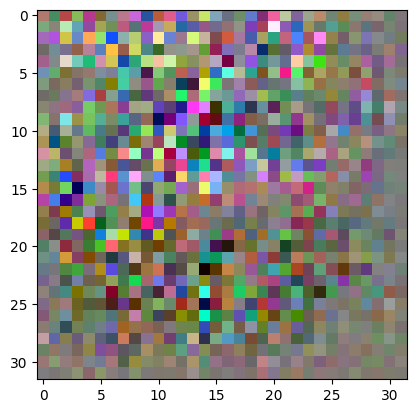

In [340]:
std_tens = torch.tensor(std).reshape(-1,1,1)
mean_tens = torch.tensor(mean).reshape(-1,1,1)
plt.imshow((clsmax.x_c[c]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


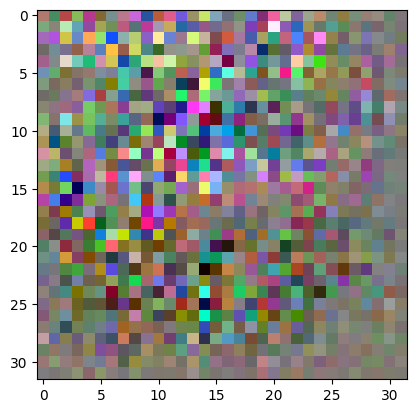

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


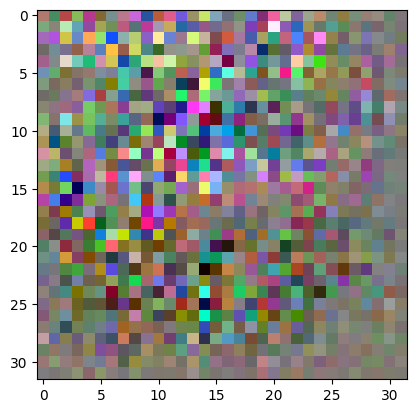

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


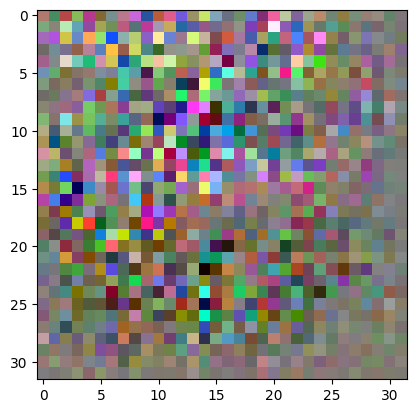

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


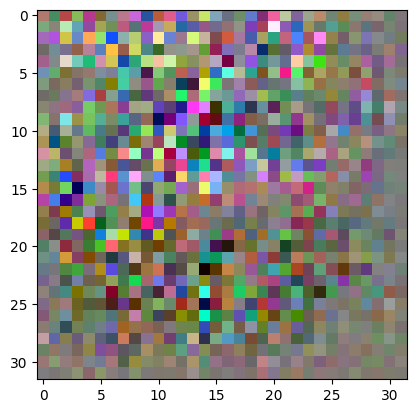

In [343]:
plt.figure()
for i in range(4):
    plt.imshow((clsmax.x_c[c]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))
    plt.show()

In [281]:
std_tens

tensor([[[0.2471]],

        [[0.2435]],

        [[0.2616]]])

In [282]:
mean_tens

tensor([[[0.4914]],

        [[0.4822]],

        [[0.4465]]])

In [328]:
out = model((clsmax.x_c[0]).unsqueeze(0))
cls_lbl = out.argmax() # model((clsmax.x_c[0]*std_tens + mean_tens).unsqueeze(0)).argmax()
# cls_lbl = model((centers[0]).unsqueeze(0)).argmax()

In [329]:
out

tensor([[ 1.6624,  0.5677,  0.2245, -0.8091, -0.0145, -0.4719, -0.1604,  0.2799,
          0.1038,  0.8313]], grad_fn=<AddmmBackward0>)

In [330]:
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [331]:
print(cifar10_classes[cls_lbl])

airplane
